# Import Modules

In [176]:
import pandas as pd
import numpy as np

#sklearn
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.similarities import MatrixSimilarity
from gensim.models import CoherenceModel, TfidfModel, LdaMulticore, Word2Vec, KeyedVectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# Visualization
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import seaborn as sns
from wordcloud import WordCloud
%matplotlib inline

# LDA
import pyLDAvis.gensim
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()
sns.set_style("darkgrid")

# Ignore warning messages
import warnings
warnings.filterwarnings('ignore')

In [268]:
# Utilize helper functions
%run helper_function.ipynb

# Import Files

In [179]:
test_df = pd.read_csv('./dataset/restaurants_data.csv', index_col=0)
keywords_df = pd.read_csv('./dataset/menu_tfidf.csv', index_col=0)
test_df.head()

,name,clean_text,menu,vegan,asian,ribs,fine,tapas,bistro,szechwan,...,fresh,puerto,gyros,cantonese,european,cream,cocktails,pub,indian,steak
0,#1 pho,fantastic pho -pron- vegetable pho vegetable b...,finely ground pork grill wooden skewer lettuce...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,24th street pizza & gyros,-pron- bad change ownership -pron- stop day ad...,tomato onion tzatziki sauce lettuce tomato oni...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3 tomatoes & a mozzarella,a cute unassume little bistro pizza go friday ...,small salad dress house balsamic vinaigrette r...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4b cafe,good consensus average home fairly easily emul...,stuff cream cheese freshly fry corn tortilla ...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5 r cha thai go,try r cha today turn permanently close very sa...,finely sliced veggie glass noodle wrap lightl...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [180]:
keywords_df.head()

,brazilian,british,cajun_creole,chinese,filipino,french,greek,indian,irish,italian,jamaican,japanese,korean,mexican,moroccan,russian,southern_us,spanish,thai,vietnamese
0,dried black beans,stilton,cajun,chinese,calamansi,gruyere cheese,feta cheese crumbles,garam masala,irish,lasagna,jerk,mirin,gochujang,taco,couscous,sauerkraut,grits,chorizo,thai,beansprouts
1,dried black,stilton cheese,cajun seasoning,oyster sauce,soy sauce bay,gruyere,cheese crumbles,garam,irish whiskey,lasagna noodles,jamaican,sake,gochujang base,taco seasoning,preserved lemon,buckwheat flour,whiskey,saffron threads,curry paste,thai
2,chocolate sprinkles,suet,andouille,shaoxing,oyster sauce,fresh tarragon,kalamata,curry leaves,irish cream liqueur,parmigiano,scotch bonnet,miso,kimchi,enchilada sauce,hanout,cottage cheese,bourbon,chorizo sausage,red curry,rice noodles
3,granola,currants,creole,hoisin,thai chile,swiss cheese,kalamata olives,dal,irish cream,parmigiano reggiano,bonnet chile,dashi,toasted sesame seeds,enchilada,ras,cottage,bourbon whiskey,spanish chorizo,red curry paste,vietnamese
4,ice lime,golden syrup,andouille sausage,hoisin sauce,thai,grated gruyère,pita,ghee,whiskey,reggiano cheese,scotch bonnet chile,nori,sauce sesame,jack cheese,ras el,buckwheat,collard greens,manchego cheese,lime leaves,thai basil


## 1) Visualize any similarities amongst restaurants using cosine similarity
We have 1199 restaurants with cuisine and restaurants attributes. I wanted to visualize if I can identify similar restaurants based on given cuisine and attributes data.

- Set Business_id column as index
- Create Cosine Similarity Matrix
- Create cosine Similarity DataFrame and plot heatmap

In [186]:
test_df.columns[3:]

Index(['vegan', 'asian', 'ribs', 'fine', 'tapas', 'bistro', 'szechwan', 'dim',
       'wraps', 'traditional',
       ...
       'fresh', 'puerto', 'gyros', 'cantonese', 'european', 'cream',
       'cocktails', 'pub', 'indian', 'steak'],
      dtype='object', length=109)

In [187]:
# Get cuisine and attrbutes
categories = list(test_df.columns[3:])

cos_df = test_df[['name'] + categories]
cos_df.set_index('name', inplace=True) # setting business_id column as index
cos_df.head()

,vegan,asian,ribs,fine,tapas,bistro,szechwan,dim,wraps,traditional,...,fresh,puerto,gyros,cantonese,european,cream,cocktails,pub,indian,steak
name,,,,,,,,,,,,,,,,,,,,,
#1 pho,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24th street pizza & gyros,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3 tomatoes & a mozzarella,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4b cafe,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5 r cha thai go,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [192]:
# Cosine Similarity
cos_sim_matrix = cosine_similarity(cos_df, cos_df)
cos_sim_matrix.shape # contains all businesses

(1199, 1199)

In [207]:
matrix_df = pd.DataFrame(data=cos_sim_matrix, 
                         index=test_df['name'].values, 
                         columns=test_df['name'].values)

matrix_df.head()

,#1 pho,24th street pizza & gyros,3 tomatoes & a mozzarella,4b cafe,5 r cha thai go,a sakura,a8 china,abacus inn chinese restaurant,acappella,agave,...,yummy house,yummy sushi,yupha's thai kitchen,yuva india kitchen + bar,yuzu,z tejas,z'tejas,zaiaka,zhen choo chinese restaurant,zpizza
#1 pho,1.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000
24th street pizza & gyros,0.0,1.000000,0.632456,0.316228,0.0,0.0,0.0,0.0,0.447214,0.365148,...,0.0,0.0,0.0,0.0,0.0,0.258199,0.258199,0.0,0.0,0.894427
3 tomatoes & a mozzarella,0.0,0.632456,1.000000,0.000000,0.0,0.0,0.0,0.0,0.707107,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.707107
4b cafe,0.0,0.316228,0.000000,1.000000,0.0,0.0,0.0,0.0,0.000000,0.577350,...,0.0,0.0,0.0,0.0,0.0,0.816497,0.816497,0.0,0.0,0.353553
5 r cha thai go,0.0,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,1.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000


#### Validating cosine similarity result
Cosine similarity result seemed to provide accurate result as shown on the result below. All the top 10 populated result seemed to produce similar Chinese restaurants given Chinese restaurant name.

In [202]:
matrix_df['abacus inn chinese restaurant'].sort_values(ascending=False)[1:10].index

Index(['oriental wok', 'abacus inn chinese restaurant', 'szechwan palace',
       'dragon express', 'china star', 'red dragon', 'red lantern',
       'little szechuan', 'new china gate'],
      dtype='object')

### 1.1 Plot HeatMap

<AxesSubplot:>

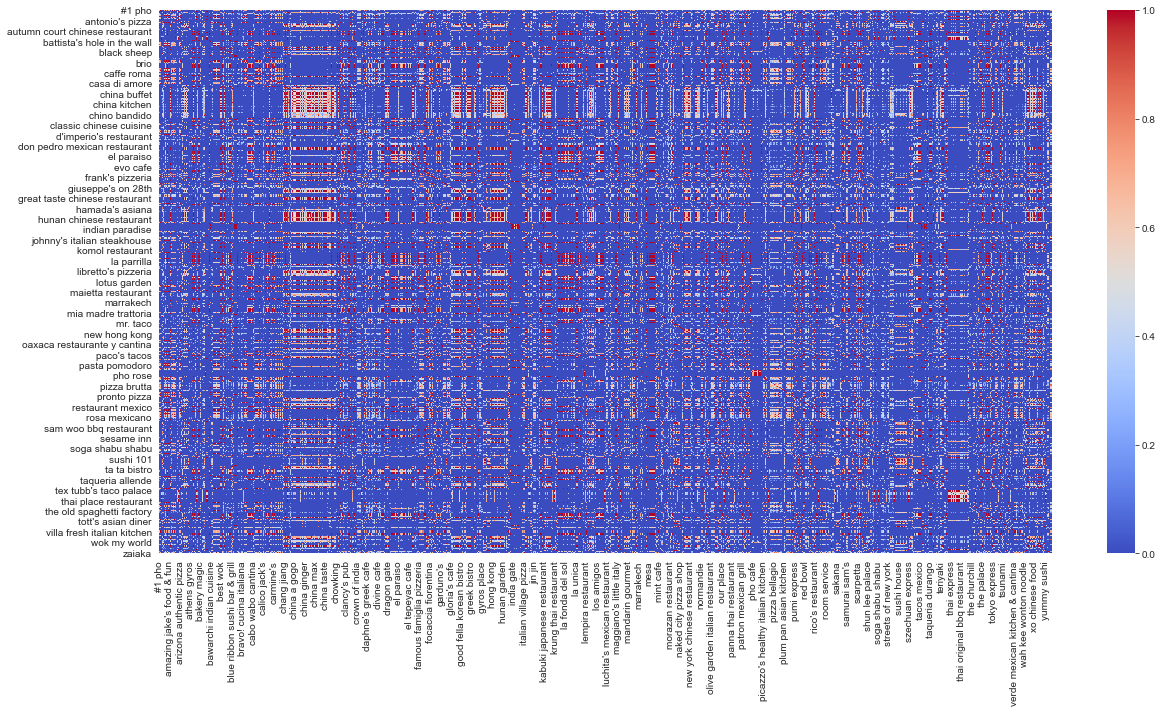

In [208]:
plt.figure(figsize=(20,10))
sns.heatmap(matrix_df, cmap='coolwarm')

In Heatmap above, cells that get closer to red are considered to have high correlation between one restaurant to another.  Considering there are red cells throughout the heatmap outside of the default diagonal line (compares restaurant to itself); it illustrates that there are many restaurants that share similar attributes and cuisine to one another.

## 2) Analyze menu description and review text
- Feature engineering.
    - Visualize top 25 most occurring categories.
    - Identify word count per each text column per row.
    - Understand text and menu documents’ word count distribution (first 400)
    - Organize text dataframe by cuisine types.
- Visualize distribution of unigram, bigram, and trigrams
    - Get top keywords from each cuisines
- Visualizing top keywords of each cuisine using word clouds based on TF-IDF.
- Most discussed by topics.

### 2.1 Feature Engineering

#### 2.1.1 Visualize top 25 most occurring categories
Check count on each restaurant category.

In [212]:
import pickle

# Open previously saved features list with its count
with open('./dataset/features.pkl', 'rb') as f:
    features = pickle.load(f)

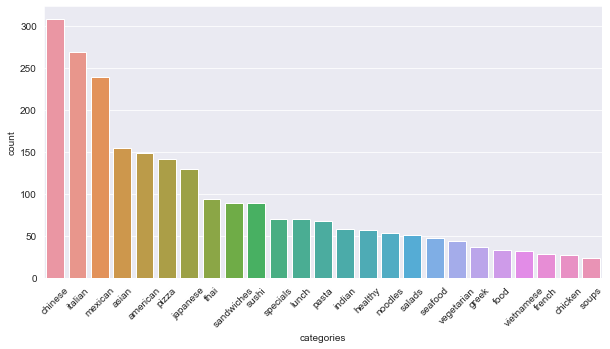

In [213]:
x_labels = [val[0] for val in features][:25]
y_labels = [val[1] for val in features][:25]

df = pd.DataFrame(data={'categories': x_labels, 'count': y_labels})

# Visualizing top 25 most occurring categories
fig, ax = plt.subplots(figsize=(10,5))
plt.xticks(rotation=45)
ax = sns.barplot(x="categories", y="count", data=df)

Bar graph illustrates that the dataset does not have equal counts of each cuisine; instead Chinese, Italian, and Mexican cuisines account for the majority of cuisines. However, we have to keep in mind that some restaurants have more than one cuisine type; for instance, one restaurant may be considered ‘Asian Fusion’ which can be Chinese, Korean, Thai, and etc. 

#### 2.1.2 Identify word count per each column per row
- Get word count per each columns per row.
- Visualize word counts for both clean_text and menu columns

In [214]:
# Get word counts per row
test_df['text_word_count'] = test_df['clean_text'].apply(lambda x: len(x.split()))
test_df['menu_desc_word_count'] = test_df['menu'].apply(lambda x: len(x.split()))

# Remove '-pron-' from text values and whitespace
test_df['clean_text'] = test_df['clean_text'].apply(lambda x: x.replace('-pron-', '')).str.strip()
test_df['menu'] = test_df['menu'].apply(lambda x: x.replace('-pron-', '')).str.strip()

In [215]:
test_df.head()

,name,clean_text,menu,vegan,asian,ribs,fine,tapas,bistro,szechwan,...,gyros,cantonese,european,cream,cocktails,pub,indian,steak,text_word_count,menu_desc_word_count
0,#1 pho,fantastic pho vegetable pho vegetable broth f...,finely ground pork grill wooden skewer lettuce...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,241,566
1,24th street pizza & gyros,bad change ownership stop day advertise pizza...,tomato onion tzatziki sauce lettuce tomato oni...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3511,210
2,3 tomatoes & a mozzarella,a cute unassume little bistro pizza go friday ...,small salad dress house balsamic vinaigrette r...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1424,419
3,4b cafe,good consensus average home fairly easily emul...,stuff cream cheese freshly fry corn tortilla c...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,259,1152
4,5 r cha thai go,try r cha today turn permanently close very sa...,finely sliced veggie glass noodle wrap lightly...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1266,1028


#### 2.1.3 Understand text and menu documents’ word count distribution (first 400)

In [216]:
text_data = list(np.array(test_df['clean_text']))
menu_data = list(np.array(test_df['menu']))

##### First 400 text documents' text count

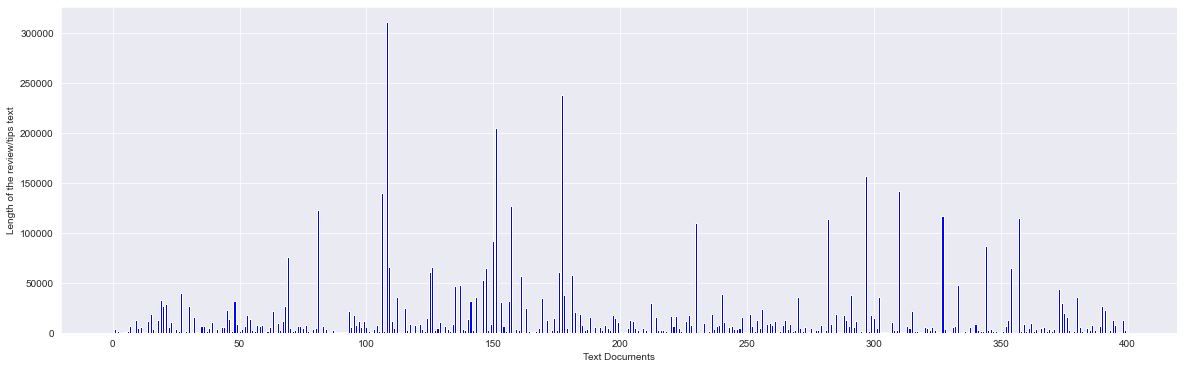

In [217]:
# Show first 400 text's word counts
plt.figure(figsize=(20, 6))
plt.bar(range(0, 400), test_df['text_word_count'].tolist()[:400], color='blue')
plt.xlabel('Text Documents')
plt.ylabel('Length of the review/tips text')
plt.show()

##### First 400 menu documents' text count

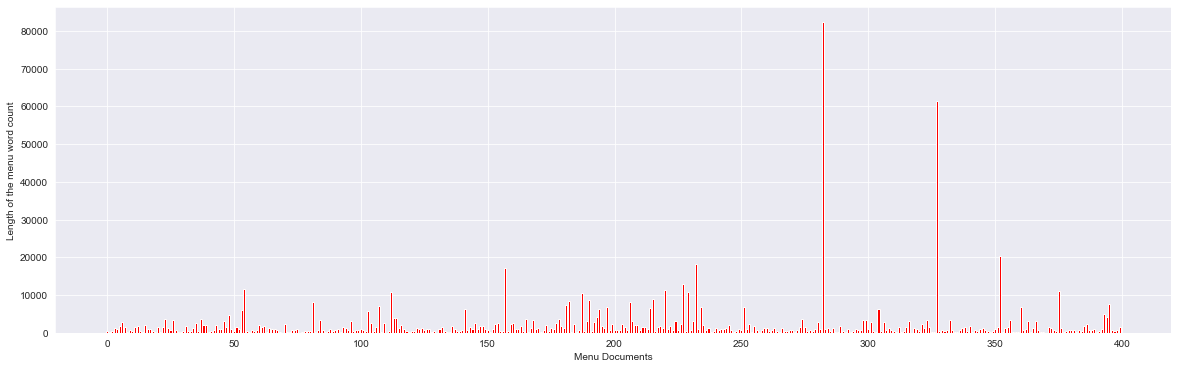

In [218]:
# Show first 400 menu's word counts
plt.figure(figsize=(20, 6))
plt.bar(range(0, 400), test_df['menu_desc_word_count'].tolist()[:400], color='red')
plt.xlabel('Menu Documents')
plt.ylabel('Length of the menu word count')
plt.show()

Text column values containing users’ reviews and tips have a lot word counts compared to menu column’s word counts. Moreover, some documents have significantly more text information compared to other documents.

##### Visualize using normal distribution

In [ ]:
sns.displot(penguins, x="flipper_length_mm", binwidth=3)

#### 2.1.2 Organize test dataframe by cuisine types
- Get cuisine list from keywords dataframe.
- Gather cuisine list based on nationalities.
- Organize cuisine dataframes by utilizing dictionary.

In [219]:
# Get cuisine list from keywords dataframe
keywords_df.columns

Index(['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino', 'french',
       'greek', 'indian', 'irish', 'italian', 'jamaican', 'japanese', 'korean',
       'mexican', 'moroccan', 'russian', 'southern_us', 'spanish', 'thai',
       'vietnamese'],
      dtype='object')

In [220]:
# Gather cuisine list based on nationalties
cuisines = [x for x in test_df.columns[8:] if x.strip() in keywords_df.columns]
cuisines.extend(['american', 'mediterranean', 'jamaican', 'hawaiian','pakistani','filipino','malaysian'])

In [221]:
cuisines

['korean',
 'mexican',
 'brazilian',
 'japanese',
 'jamaican',
 'irish',
 'russian',
 'italian',
 'french',
 'greek',
 'thai',
 'chinese',
 'vietnamese',
 'moroccan',
 'british',
 'filipino',
 'spanish',
 'indian',
 'american',
 'mediterranean',
 'jamaican',
 'hawaiian',
 'pakistani',
 'filipino',
 'malaysian']

In [222]:
# Sample
test_df[test_df['japanese'] == 1][['clean_text','menu']]

,clean_text,menu
5,this sushi spot madison cute decor portion var...,mushroom onion sweet squid seaweed mix five pi...
26,remember narita and arata all sorry stop th...,enoki silken tofu seaweed scallion fresh lobst...
31,order spicy tuna roll eel roll steam dumpling ...,fry bean curd tempura sauce steamed japanese s...
35,chinese same mall lunch well mall prompt hot ...,oz cup piece piece piece vegetable egg roll so...
40,visit asuka gift certificate planning spend ov...,toro blue fin tuna yellowtail salmon albacore ...
...,...,...
1183,be valley fancy sushi w pure bar far fresh fis...,manager recommendation manager recommendation ...
1186,from town visit yogi vegas twice beef beef rib...,teriyaki chicken serve white brown steamed ric...
1187,fast food good alternative bk mickey d taco be...,teriyaki chicken orange chicken beef regular f...
1190,this faux sushi raw spicy shrimp roll lobster ...,soybean soup tofu seaweed scallion soybean sou...


In [223]:
# Organize cuisine dataframes by utilizing dictionary.
attributes_list = test_df.iloc[:, 8:].columns
attributes_list

Index(['bistro', 'szechwan', 'dim', 'wraps', 'traditional', 'korean',
       'mexican', 'fusion', 'deli', 'noodles',
       ...
       'gyros', 'cantonese', 'european', 'cream', 'cocktails', 'pub', 'indian',
       'steak', 'text_word_count', 'menu_desc_word_count'],
      dtype='object', length=106)

In [224]:
# Get clean text columns along with other attributes columns
text_df = test_df[['clean_text','menu'] + list(attributes_list)]
text_df.head()

,clean_text,menu,bistro,szechwan,dim,wraps,traditional,korean,mexican,fusion,...,gyros,cantonese,european,cream,cocktails,pub,indian,steak,text_word_count,menu_desc_word_count
0,fantastic pho vegetable pho vegetable broth f...,finely ground pork grill wooden skewer lettuce...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,241,566
1,bad change ownership stop day advertise pizza...,tomato onion tzatziki sauce lettuce tomato oni...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3511,210
2,a cute unassume little bistro pizza go friday ...,small salad dress house balsamic vinaigrette r...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1424,419
3,good consensus average home fairly easily emul...,stuff cream cheese freshly fry corn tortilla c...,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,259,1152
4,try r cha today turn permanently close very sa...,finely sliced veggie glass noodle wrap lightly...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1266,1028


In [225]:
text_df.columns[:2]

Index(['clean_text', 'menu'], dtype='object')

In [226]:
list(text_df.columns[-2:])

['text_word_count', 'menu_desc_word_count']

In [227]:
# Get text and text count columns
text_cols = list(text_df.columns[:2])
count_cols = list(text_df.columns[-2:])

# Combine
cols = text_cols + count_cols

In [228]:
# Organize cuisine dataframes by utilizing dictionary.
cuisine_dict = {}
dfs = [] # Create master cuisine list

# Gather cuisine and key it by cuisine type onto dictionary
for cuisine in cuisines:
    cuisine_df = text_df[text_df[cuisine] == 1][cols].reset_index(drop=True)
    cuisine_df['cuisine'] = cuisine
    cuisine_dict[cuisine] = cuisine_df
    dfs.append(cuisine_df)

all_cuisine_df = pd.concat(dfs)
all_cuisine_df.reset_index(drop=True, inplace=True)

In [229]:
# Sample
cuisine_dict['japanese'].head()

,clean_text,menu,text_word_count,menu_desc_word_count,cuisine
0,this sushi spot madison cute decor portion var...,mushroom onion sweet squid seaweed mix five pi...,960,1850,japanese
1,remember narita and arata all sorry stop th...,enoki silken tofu seaweed scallion fresh lobst...,1953,3282,japanese
2,order spicy tuna roll eel roll steam dumpling ...,fry bean curd tempura sauce steamed japanese s...,321,1914,japanese
3,chinese same mall lunch well mall prompt hot ...,oz cup piece piece piece vegetable egg roll so...,6762,2586,japanese
4,visit asuka gift certificate planning spend ov...,toro blue fin tuna yellowtail salmon albacore ...,525,327,japanese


In [230]:
text_count_df = all_cuisine_df.iloc[:, 2:]
text_count_df.head(3)

,text_word_count,menu_desc_word_count,cuisine
0,1075,1831,korean
1,2596,583,korean
2,4422,766,korean


In [231]:
# Structuring dataframe to meet seaborn's catplot parameters
melted_df = text_count_df.melt(id_vars=['cuisine'], 
                              var_name='word_count_type', 
                              value_name='word_count')

melted_df.head(10)

,cuisine,word_count_type,word_count
0,korean,text_word_count,1075
1,korean,text_word_count,2596
2,korean,text_word_count,4422
3,korean,text_word_count,9340
4,korean,text_word_count,9591
5,korean,text_word_count,30956
6,korean,text_word_count,123
7,korean,text_word_count,8308
8,korean,text_word_count,4980
9,korean,text_word_count,7174


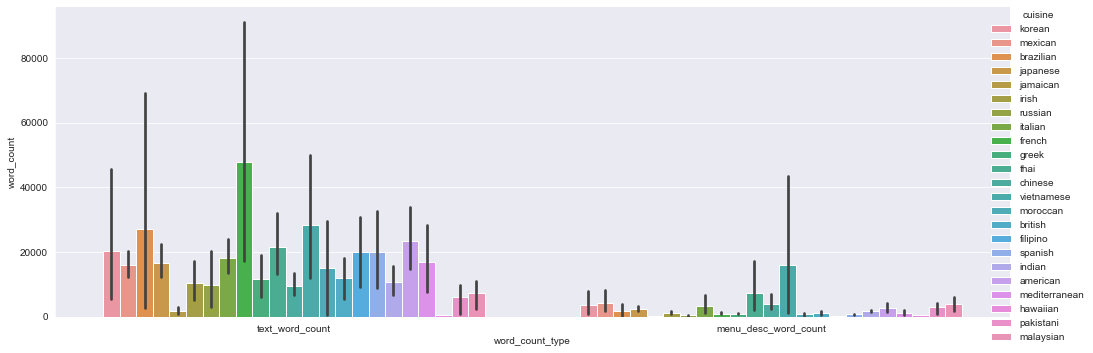

In [232]:
# Plotting text, menu description, and menu titles textcount per cuisine
g = sns.catplot(x="word_count_type", y="word_count", hue="cuisine", kind="bar", aspect=4, data=melted_df)
g.fig.set_figwidth(15)
g.fig.set_figheight(5)

In terms of word count distribution per cuisine; French cuisine has the most word count compared to others although French cuisine restaurants appeared low in categories count bar graph. This explains that there are not that many French restaurants listed but with many reviews. Additionally, error bars are apparent on most cuisines, explaining to us that word counts are highly spread out. For instance, one document having 3,000 word count while other having less than 100 word count. 

Understanding that some cuisines have higher word counts and frequencies than others; it may be a challenge in accurately identifying certain type of cuisines using doc2vec due to not having sufficient information compared to other cuisines such as French, Chinese, and Italian.

### 2.2 Visualize distribution of unigram, bigram, and trigrams
Displaying unigram, bigram, and trigrams of consolidated cuisines' text information.

#### Gather and visualize unigram, bigrams, and trigrams

In [233]:
# Accepts series, top n key words, n_gram
unigrams = get_top_n_words(test_df['menu'], 10, 1)
bigrams = get_top_n_words(test_df['menu'], 10, 2)
trigrams = get_top_n_words(test_df['menu'], 10, 3)

In [234]:
# Sample
trigrams

[('warm flour tortilla', 4285),
 ('soft flour tortilla', 3520),
 ('nacho cheese sauce', 3424),
 ('warm nacho cheese', 3263),
 ('spicy hot spicy', 3196),
 ('hot spicy hot', 3189),
 ('fat sour cream', 2808),
 ('reduce fat sour', 2392),
 ('egg foo young', 2335),
 ('item lacto ovo', 2309)]

In [235]:
def unpack(tuples):
    x_labels = [val[0] for val in tuples]
    y_labels = [val[1] for val in tuples]
    return x_labels, y_labels

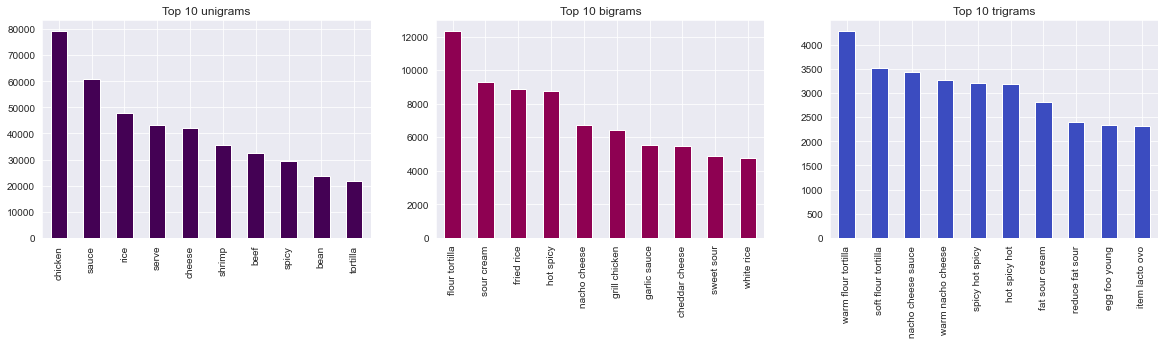

In [236]:
# Adjust size
plt.figure(figsize=(20,4))

# Unigrams
ax_one = plt.subplot(1,3,1)
x_labels, y_labels = unpack(unigrams) # Get labels - x = words, y = word count
ax = pd.Series(y_labels).plot(kind='bar', cmap='viridis', ax=ax_one) # Plot bar graph
ax.set_xticklabels(x_labels) # Add x labels
ax_one.set_title('Top 10 unigrams');

# Bigrams
ax_two = plt.subplot(1,3,2)
x_labels, y_labels = unpack(bigrams)
ax = pd.Series(y_labels).plot(kind='bar', cmap='PiYG', ax=ax_two)
ax.set_xticklabels(x_labels)
ax_two.set_title('Top 10 bigrams');

# Trigrams
ax_three = plt.subplot(1,3,3)
x_labels, y_labels = unpack(trigrams)
ax = pd.Series(y_labels).plot(kind='bar', cmap='coolwarm', ax=ax_three)
ax.set_xticklabels(x_labels)
ax_three.set_title('Top 10 trigrams');

Based on the given information above, the top 10 most common words seem to be flour, spicy, tortilla, sauce, and milk related terms.

### 2.3 Visualizing top keywords of each cuisine using word clouds based on TF-IDF
TF-IDF measurement is used to evaluate how relevant each word is based on weight. Therefore, only retrieving import keywords for each cuisine.  With the TF-IDF values, I validated whether given keywords on each cuisine based on my subjective judgement. For example, I would expect to see ‘sushi’ in Japanese cuisine as opposed to appearing in Irish cuisine. 

In [243]:
# Menu column
indian_menu_cloud = generate_wordcloud(test_df, 'indian', 'menu')
japanese_menu_cloud = generate_wordcloud(test_df, 'japanese', 'menu')
mexican_menu_cloud = generate_wordcloud(test_df, 'mexican', 'menu')

# Clean text column
indian_text_cloud = generate_wordcloud(test_df, 'indian', 'clean_text')
japanese_text_cloud = generate_wordcloud(test_df, 'japanese', 'clean_text')
mexican_text_cloud = generate_wordcloud(test_df, 'mexican', 'clean_text')

menu_clouds = [indian_menu_cloud, japanese_menu_cloud, mexican_menu_cloud, 
               indian_text_cloud, japanese_text_cloud, mexican_text_cloud]
cloud_titles = ['Indian Menu', 'Japanese Menu', 'Mexican Menu', 'Indian Text', 'Japanese Text', 'Mexican Text']

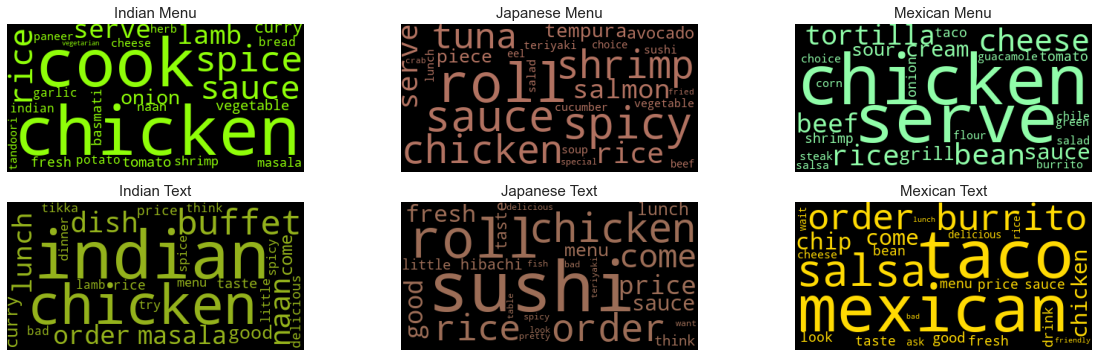

In [244]:
fig, axes = plt.subplots(2, 3, figsize=(20,6))

for i, ax in enumerate(axes.flatten(), 0):
    fig.add_subplot(ax)
    plt.gca().imshow(menu_clouds[i]) # imshow - display data as image
    plt.gca().set_title(cloud_titles[i], fontdict=dict(size=15)) # setting title
    plt.gca().axis('off') # removing axis

Based on the word clouds above using both text and menu documents, I can conclude that the majority of the documents provided are relevant relative to its cuisine type.

## 3) Analyzing text documents through LDA modeling
Unlike menu documents, text documents consists of Yelp’s review and tips dataset and text information isn’t primarily always focused on food and drinks; it also contains information regarding restaurants’ service, ambience, and other miscellaneous information. Therefore, I wanted to see if any hidden structure in a collection of texts uncovered through topic modeling can be useful for the search engine.
- Phrase Modeling: Build Bigram and Trigram list
- Topic Modeling
    * Data Transformation: Dictionary and Corpus
    * TF-IDF
    * LDA
- Dominant Topics
    * Dominant topic and its percentage contribution in each document
    * Frequency distribution of word counts in documents
- Create Document Term Matrix (DTM) to TF-IDF
- Display # of positive and # of negative review types based on user's average star rating

### 3.1 Phrase Modeling: Build bigram and trigram models
Create bigrams and trigrams for all text values:
- Reviews and tips
- Menu Description
- Menu Titles

#### Create bigrams and trigrams

In [246]:
# Review text and tips
text_bigrams_list, text_trigrams_list = get_bigrams_trigrams_list(test_df['clean_text'])

### 3.2 Topic Modeling
Data Transformation: Create dictionary and corpus for all text values. Creating unique id for each word in the document.

In [248]:
# Review and tips
text_id2word = corpora.Dictionary(text_trigrams_list)

In [249]:
# checking first 10 keys in a dictionary
first_ten = dict(list(text_id2word.items())[0: 10])
first_ten

{0: 'adequate',
 1: 'afternoon',
 2: 'alot',
 3: 'area',
 4: 'arrive',
 5: 'as',
 6: 'available',
 7: 'ave',
 8: 'bad',
 9: 'basil'}

Filter out tokens that appear in less than 10 times and appears more than 50% of all documents and keep only 100,000 most frequenct tokens

In [250]:
text_id2word.filter_extremes(no_below=10, no_above=0.50, keep_n=100000)

In [251]:
# Term document frequency - corpus
text_bow_corpus = [text_id2word.doc2bow(text) for text in text_trigrams_list]

# TF-IDF corpus
text_tfidf = TfidfModel(text_bow_corpus)

text_tfidf_corpus = text_tfidf[text_bow_corpus]

In [252]:
# Sample how it tfidf_corpus looks in human readable format
[[(text_id2word[key], freq) for key, freq in cp] for cp in text_tfidf_corpus[:1]]

[[('adequate', 0.038990436005358946),
  ('afternoon', 0.022288981691689188),
  ('alot', 0.03548661888487032),
  ('ave', 0.06304842890617714),
  ('basil', 0.07816179038291454),
  ('bean_sprout', 0.060289922370687865),
  ('because', 0.02645529101630614),
  ('beloved', 0.06987693191594546),
  ('broth', 0.0545158127315993),
  ('bubble', 0.0703564423311906),
  ('bubble_tea', 0.09713343853890719),
  ('contain', 0.03153366952893374),
  ('create', 0.030066546195473758),
  ('downside', 0.03605822930555272),
  ('enjoyed', 0.06523467595782127),
  ('extension', 0.11554220220311968),
  ('fabulous', 0.023488286328641073),
  ('feeling', 0.024161977057338645),
  ('harden', 0.09497079014478688),
  ('hardened', 0.1357113489146227),
  ('incense', 0.13970240624248606),
  ('mystery', 0.05406782652245521),
  ('original', 0.024504236247164208),
  ('paper', 0.02750898515686296),
  ('parfait', 0.11178647318849164),
  ('permanently', 0.0801804894988348),
  ('pho', 0.8588887627591569),
  ('possible', 0.022182158

#### Compute Coherence Score
Coherence measures the relative distance between words within a topic. The overall coherence score of a topic is the average of the distances between words. (0 - 1) Ideal score is between 0.55 - 0.7, anything above 0.7 is too good to be true because it means most words are identical which is highly unlikely.

In [269]:
# Coherence score parameters
topics=24; start=2; step=4;

# InitialCan take a long time to run.
tfidf_model_list, coherence_values, lda_tuning_results_df = compute_coherence_values(text_id2word, 
                                                              text_tfidf_corpus, 
                                                              text_trigrams_list, 
                                                              topics, # Check up to 24 topics
                                                              start, # Start at 2 topics
                                                              step) # Increment by 4 on each iteration of tests

##### Saving files

In [283]:
with open('./dataset/id2word.pkl', 'wb') as pickle_file:
    pickle.dump(text_id2word, pickle_file)

with open('./dataset/tfidf_corpus.pkl', 'wb') as pickle_file:
    pickle.dump(text_tfidf_corpus, pickle_file)

In [280]:
with open('./dataset/coherence_values.pkl', 'wb') as pickle_file:
    pickle.dump(coherence_values, pickle_file)

In [284]:
with open('./dataset/tfidf_model_list.pkl', 'wb') as pickle_file:
    pickle.dump(tfidf_model_list, pickle_file)

In [285]:
lda_tuning_results_df.to_csv('./dataset/lda_tuning_results.csv')

In [288]:
lda_tuning_results_df

,Topics,Alpha,Beta,Coherence
0,2,0.01,0.01,0.274898
1,2,0.01,0.31,0.275162
2,2,0.01,0.61,0.276663
3,2,0.01,0.91,0.308043
4,2,0.01,symmetric,0.273772
...,...,...,...,...
175,22,asymmetric,0.01,0.352827
176,22,asymmetric,0.31,0.330031
177,22,asymmetric,0.61,0.331503
178,22,asymmetric,0.91,0.331503


In [289]:
# Find top coherence scores
lda_tuning_results_df = lda_tuning_results_df.sort_values(by=['Coherence'], ascending=False)
lda_tuning_results_df.head()

,Topics,Alpha,Beta,Coherence
50,6,symmetric,0.01,0.477292
99,14,0.31,symmetric,0.471563
65,10,0.31,0.01,0.464605
30,6,0.01,0.01,0.458272
35,6,0.31,0.01,0.456636


#### Identifying optimal number of topics

LDA model with 6 topics, symmetric alpha, and beta value of 0.01 got the best performance with coherence score of 0.48

In [298]:
# ex: chunksize = 100, update_every=1, corpus = 1M docs, passes =4 : 40 updates total
optimal_tfidf_lda_model = LdaMulticore(text_tfidf_corpus, # tream of document vectors 
                               id2word=text_id2word, # mapping from word IDs to words
                               num_topics=6,  # number of requested latent topics to be extracted from the training corpus
                               chunksize=100, # number of docs to be used in each training chunk
                               random_state=42, # to ensure same result
                               alpha = 'symmetric',
                               eta = 0.01,
                               eval_every=None, # don't evaluate model perplexity - takes too long
                               passes=2, # number of passes through the corpus during training
                               workers=4)

In [299]:
optimal_tfidf_lda_model.print_topics()

[(0,
  '0.019*"thai" + 0.015*"mexican" + 0.015*"salsa" + 0.015*"taco" + 0.011*"burrito" + 0.007*"pad" + 0.007*"chip" + 0.005*"guacamole" + 0.005*"enchiladas" + 0.005*"curry"'),
 (1,
  '0.008*"gyro" + 0.005*"russian" + 0.005*"chinese" + 0.004*"brazilian" + 0.004*"teppanyaki" + 0.003*"market_square" + 0.003*"pizza" + 0.003*"banh_mi" + 0.003*"macaron" + 0.003*"milano"'),
 (2,
  '0.035*"indian" + 0.025*"naan" + 0.011*"gyro" + 0.010*"buffet" + 0.010*"tikka_masala" + 0.007*"pupusa" + 0.006*"tandoori" + 0.006*"falafel" + 0.006*"samosas" + 0.006*"curry"'),
 (3,
  '0.013*"pizza" + 0.011*"chinese" + 0.004*"italian" + 0.004*"pasta" + 0.003*"vegas" + 0.003*"thai" + 0.003*"pho" + 0.003*"wing" + 0.003*"general_tso" + 0.003*"lo_mein"'),
 (4,
  '0.008*"chinese" + 0.005*"sakura" + 0.004*"kobe" + 0.004*"filipino" + 0.003*"bento" + 0.003*"italian" + 0.003*"pasta" + 0.003*"korean_bbq" + 0.003*"general_tso" + 0.002*"cambodian"'),
 (5,
  '0.067*"sushi" + 0.012*"hibachi" + 0.008*"tuna" + 0.008*"sashimi" + 0.

In [300]:
# Compute Coherence Score
optimal_coherence_model_lda = CoherenceModel(model=optimal_tfidf_lda_model, 
                                             texts=text_trigrams_list, 
                                             dictionary=text_id2word, 
                                             coherence='c_v')
optimal_coherence_lda = optimal_coherence_model_lda.get_coherence()
optimal_coherence_lda

0.4772918588724819

In [301]:
optimal_LDAvis_prepared = pyLDAvis.gensim.prepare(optimal_tfidf_lda_model, text_tfidf_corpus, text_id2word)    
optimal_LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.033807 -0.126877       1        1  68.185501
0     -0.172660  0.021945       2        1  18.885057
2      0.065285  0.120361       3        1   4.288732
5      0.006558 -0.032682       4        1   4.029120
4      0.039673 -0.002985       5        1   2.321655
1      0.027337  0.020237       6        1   2.289930, topic_info=          Term        Freq       Total Category  logprob  loglift
1093     sushi   60.000000   60.000000  Default  30.0000  30.0000
1157   chinese  112.000000  112.000000  Default  29.0000  29.0000
4643    indian   23.000000   23.000000  Default  28.0000  28.0000
45        thai   75.000000   75.000000  Default  27.0000  27.0000
835    mexican   46.000000   46.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
835    mexican    0.609394   46.549290   Topic6  -6.1749  -0.5592
405      pasta    0.595601   43.311577   Topic6  -6.1978  -0.5100
465   sandwich    0.542967   20.318140   Topic6  -6.2903   0.1544
844      salsa    0.513634   48.341541   Topic6  -6.3459  -0.7679
2042   burrito    0.502928   35.698765   Topic6  -6.3669  -0.4858

[412 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
1944       2  0.827894         agave
1944       6  0.827894         agave
13220      3  1.288839     aloo_gobi
6832       1  0.846736       amenity
5517       3  1.349086         annie
...      ...       ...           ...
1904       5  0.039727        wonton
17212      2  1.002222    yard_house
996        2  1.029453  yellow_curry
9725       4  0.659999    yellowtail
7909       1  0.657234            za

[437 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 6, 5, 2])